In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import pingouin as pg

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype']=42
%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42 
mpl.rcParams['font.sans-serif']=['Arial', 'Helvetica','Bitstream Vera Sans', 'DejaVu Sans', 'Lucida Grande', 
                                 'Verdana', 'Geneva', 'Lucid', 'Avant Garde', 'sans-serif'] 

def set_pub_plots(pal=sns.blend_palette(["gray","crimson", 'cyan', 'magenta', 'purple' ],5)):
    sns.set_style("white")
    sns.set_palette(pal)
    sns.set_context("poster", font_scale=1.5, rc={"lines.linewidth": 2.5, "axes.linewidth":2.5}) 
    sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
    # optional, makes markers bigger, too, axes.linewidth doesn't seem to work
    plt.rcParams['axes.linewidth'] = 2.5

rc_pub={'font.size': 25, 'axes.labelsize': 25, 'legend.fontsize': 25.0, 
    'axes.titlesize': 25, 'xtick.labelsize': 25, 'ytick.labelsize': 25, 
    #'axes.color_cycle':pal, # image.cmap - rewritesd the default colormap
    'axes.linewidth':2.5, 'lines.linewidth': 2.5,
    'xtick.color': 'black', 'ytick.color': 'black', 'axes.edgecolor': 'black','axes.labelcolor':'black','text.color':'black'}
# to restore the defaults, call plt.rcdefaults() 

#set_pub_bargraphs()
set_pub_plots()

%load_ext autoreload
%autoreload 2

import scipy.signal as sg
sns.set_context("poster")
sns.set_style("ticks")

# STAGE 4 ANALYSIS (DELAYED GO/NO-GO) WITH LASER INHIBITION

## LOADING FILES

In [6]:
filedir=r'U:\Data\snareddu\behavioral opto'
frrwdfiles=glob.glob(filedir+'\TEST DAY NO*\*.csv')
frrwdfiles

['U:\\Data\\snareddu\\behavioral opto\\TEST DAY NO NOVEL\\WINDOWS-PJJ0GDK_PVCreExp_Stage 4 Pink noise loc discrimination_oneatatimevideo_v6_novel_withopto_972-et335.csv',
 'U:\\Data\\snareddu\\behavioral opto\\TEST DAY NO NOVEL\\WINDOWS-PJJ0GDK_PVCreExp_Stage 4 Pink noise loc discrimination_oneatatimevideo_v6_novel_withopto_973-et336.csv',
 'U:\\Data\\snareddu\\behavioral opto\\TEST DAY NO NOVEL\\WINDOWS-PJJ0GDK_PVCreExp_Stage 4 Pink noise loc discrimination_oneatatimevideo_v6_novel_withopto_977-et338.csv',
 'U:\\Data\\snareddu\\behavioral opto\\TEST DAY NO NOVEL\\WINDOWS-PJJ0GDK_PVCreExp_Stage 4 Pink noise loc discrimination_oneatatimevideo_v6_novel_withopto_978-et334.csv',
 'U:\\Data\\snareddu\\behavioral opto\\TEST DAY NO NOVEL 2\\WINDOWS-PJJ0GDK_PVCreExp_Stage 4 Pink noise loc discrimination_oneatatimevideo_v6_novel_withopto_957-et279.csv',
 'U:\\Data\\snareddu\\behavioral opto\\TEST DAY NO NOVEL 2\\WINDOWS-PJJ0GDK_PVCreExp_Stage 4 Pink noise loc discrimination_oneatatimevideo_v6_n

## CREATING DATAFRAME

In [8]:
dfls=[]
for iii,f in enumerate(frrwdfiles):
    
    if iii%50==0:
        print(f'done loading {iii} out of {len(frrwdfiles)}')
    
    infodf=pd.read_csv(f,names=['Name','Value',''],skiprows=np.arange(17,100000*2,1)) ###10000 here
#     day=int(f.split('\\')[-2][3:])
    day=1
    et=f.split('_')[-1].split('.')[0].split('-')[-1][-3:]
    idn=f.split('oneatatimevideo_')[-1].split('-')[-1][:-4]

    try:
        tmpdf=pd.read_csv(f,skiprows=17)
        if 'Evnt_Time' not in tmpdf.columns:
            tmpdf=pd.read_csv(f,skiprows=17,header=1)
    except:
        print(f,'not read')
        
    startcorr=tmpdf[(tmpdf.Group_ID==2)
                 &(tmpdf.Item_Name.str.contains('correction'))
                 ].Evnt_Time.values
    if 'withopto' in f:
        laseront=tmpdf[(tmpdf.Group_ID==4)
                      &(tmpdf.Item_Name=='Laser #1')
                      ].Evnt_Time.values
    dispmov1t=tmpdf[(tmpdf.Group_ID==3)
                   &(tmpdf.Evnt_Name.str.contains('Play Video'))
                   &(tmpdf.Arg2_Name=='Video 1')  
                   ].Evnt_Time.values
    dispmov2t=tmpdf[(tmpdf.Group_ID==3)
                    &(tmpdf.Evnt_Name.str.contains('Play Video'))
                    &(tmpdf.Arg2_Name=='Video 2')  
                   ].Evnt_Time.values
    dispgrayt=tmpdf[(tmpdf.Group_ID==5)
                  &(tmpdf.Item_Name.str.contains('displaygray'))
                   ].Evnt_Time.values
    
    
    mov1cortoucht=tmpdf[(tmpdf.Group_ID==6)
                        &(tmpdf.Item_Name=='loccorrecttouch')
                       ].Evnt_Time.values
    mov2notoucht=tmpdf[(tmpdf.Group_ID==6)
                        &(tmpdf.Item_Name=='loccorrnotouch')
                       ].Evnt_Time.values
    mov1notoucht=tmpdf[(tmpdf.Group_ID==6)
                        &(tmpdf.Item_Name=='locincnotouch')
                       ].Evnt_Time.values
    mov2inctoucht=tmpdf[(tmpdf.Group_ID==6)
                        &(tmpdf.Item_Name=='locinctouch')
                       ].Evnt_Time.values
    mov2notouchcorrectiont=tmpdf[(tmpdf.Group_ID==6)
                                &(tmpdf.Item_Name=='locinctouchcorrection')
                               ].Evnt_Time.values
    mov1touchcorrectiont=tmpdf[(tmpdf.Group_ID==6)
                              &(tmpdf.Item_Name=='locincnotouchcorrection')
                              ].Evnt_Time.values
    trayentryt=tmpdf[(tmpdf.Group_ID==12)
                     &(tmpdf.Evnt_Name.str.contains('On Event'))
                    ].Evnt_Time.values
  
    onesessionls=[]
    stim_time_ls=[]
    tr_ls=[]
    alldispt=sorted(np.hstack([dispmov1t,dispmov2t]))
    alldispstim=[(i in dispmov1t) for i in alldispt]
    alldispt.append(tmpdf.Evnt_Time.max())
    tr=0
    tr2=0
    for i,t0 in enumerate(alldispt[:-1]):
        CorrT=0
        t0,t1=alldispt[i],alldispt[i+1]
        if t0 in dispmov1t:
            stim=1
            tr=tr+1
            tr_ls.append(tr)
        else:
            stim=2
            tr2=tr2+1
            tr_ls.append(tr2)
        if stim==1:
   
            t_movtoucht=mov1cortoucht[(mov1cortoucht>t0)&(mov1cortoucht<t1)] 
            t_movnotoucht=mov1notoucht[(mov1notoucht>t0)&(mov1notoucht<t1)]
            t_movcorrrectiont=mov1touchcorrectiont[(mov1touchcorrectiont>t0)&(mov1touchcorrectiont<t1)]
            t_trayentryt=trayentryt[(trayentryt>t0)&(trayentryt<t1)]
            if t_movnotoucht.shape[0]:
                CorrT=1
        elif stim==2:
            t_movnotoucht=mov2notoucht[(mov2notoucht>t0)&(mov2notoucht<t1)]
            t_movtoucht=mov2inctoucht[(mov2inctoucht>t0)&(mov2inctoucht<t1)]
            t_movcorrrectiont=mov2notouchcorrectiont[(mov2notouchcorrectiont>t0)&(mov2notouchcorrectiont<t1)]
            if t_movtoucht.shape[0]:  
                CorrT=1
                 
        if t_movcorrrectiont.shape[0]:
            CorrT=1
        if i>=1:
            start_corr_t=startcorr[(startcorr<t0)&(startcorr>alldispt[i-1])]
        if t_movtoucht.shape[0] or t_movcorrrectiont.shape[0]:
            disp2touch=min(np.hstack([t_movtoucht,t_movcorrrectiont])-t0)
            if stim==1 and t_movcorrrectiont.shape[0]>0:
                disp2touch=np.nan
            if stim==1 and len(t_trayentryt):
                touch2entry=min(t_trayentryt-t_movtoucht)
            else:
                touch2entry=np.nan
        else:
            disp2touch=np.nan
            touch2entry=np.nan
        if t_movnotoucht.shape[0]:
            disp2touch=np.nan
            touch2entry=np.nan
        if 'withopto' in f:
            laseron=laseront[abs(laseront-t0)<5+0.5]
            onesessionls.append((i,t0,stim,disp2touch,touch2entry,len(laseron),CorrT))
            stim_time_ls.append(t0)
        else:
            onesessionls.append((i,t0,stim,disp2touch,touch2entry,np.nan,CorrT))
            stim_time_ls.append(t0)
    x=np.array(stim_time_ls[1:])-np.array(stim_time_ls[:-1])
    iti = np.concatenate([x,np.array([0])])
    
    onesessiondf=pd.DataFrame(onesessionls,columns=['trial','stim_time','stim','disp2touch','touch2entry','laser','CorrT'])
    onesessiondf['stim_time']=onesessiondf['stim_time']-onesessiondf.stim_time.values[0]
    onesessiondf['et']=et
    onesessiondf['day']=day
    onesessiondf['idn']=idn
    onesessiondf['iti']=iti
    onesessiondf['tr_uq']=tr_ls
    dfls.append(onesessiondf)
allsessiondf=pd.concat(dfls)
allsessiondf['uid']=allsessiondf['idn']+'_'+allsessiondf['trial'].astype(str)
allsessiondf.head(10)


done loading 0 out of 8


,trial,stim_time,stim,disp2touch,touch2entry,laser,CorrT,et,day,idn,iti,tr_uq,uid
0,0,0.000,2,NaN,NaN,0,0,335,1,et335,12.490,1,et335_0
1,1,12.490,1,NaN,NaN,0,1,335,1,et335,17.474,1,et335_1
2,2,29.964,2,NaN,NaN,0,0,335,1,et335,12.508,2,et335_2
3,3,42.472,1,NaN,NaN,0,1,335,1,et335,17.501,2,et335_3
4,4,59.973,1,NaN,NaN,0,1,335,1,et335,17.482,3,et335_4
5,5,77.455,2,NaN,NaN,0,0,335,1,et335,12.505,3,et335_5
6,6,89.960,2,NaN,NaN,0,0,335,1,et335,12.533,4,et335_6
7,7,102.493,2,NaN,NaN,0,0,335,1,et335,12.505,5,et335_7
8,8,114.998,2,NaN,NaN,0,0,335,1,et335,12.492,6,et335_8
9,9,127.490,2,NaN,NaN,0,0,335,1,et335,12.478,7,et335_9


### ADDING UNIQUE TRIAL ID (COUNT) FOR ALL STIM SITUATIONS

In [9]:
allsessiondf['new_id'] = -1
tmp_ls=[]
for s,ss in allsessiondf.groupby(['stim','laser','et']):
    i = 1
    for j in range(len(ss['new_id'])):
        ss['new_id'].iloc[j] = i
        i = i+1
    tmp_ls.append(ss)
tmp_df=pd.concat(tmp_ls,ignore_index=True)
tmp_df.head(10)

C:\Users\AChub_Lab\anaconda3\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,trial,stim_time,stim,disp2touch,touch2entry,laser,CorrT,et,day,idn,iti,tr_uq,uid,new_id
0,1,20.500,1,NaN,NaN,0,1,277,1,et277,17.494,1,et277_1,1
1,3,50.498,1,NaN,NaN,0,1,277,1,et277,17.502,2,et277_3,2
2,4,68.000,1,NaN,NaN,0,1,277,1,et277,17.497,3,et277_4,3
3,11,170.492,1,NaN,NaN,0,1,277,1,et277,17.498,4,et277_11,4
4,12,187.990,1,NaN,NaN,0,1,277,1,et277,17.494,5,et277_12,5
5,14,224.775,1,NaN,NaN,0,1,277,1,et277,17.502,6,et277_14,6
6,15,242.277,1,NaN,NaN,0,1,277,1,et277,25.756,7,et277_15,7
7,16,268.033,1,NaN,NaN,0,1,277,1,et277,23.301,8,et277_16,8
8,18,303.117,1,1.813,6.557,0,0,277,1,et277,19.658,9,et277_18,9
9,19,322.775,1,NaN,NaN,0,1,277,1,et277,17.466,10,et277_19,10


### CREATING DATAFRAME FOR PERCENTAGE OF TOUCHES


In [10]:
report_directory=r'U:\Data\Violet\Optio IA32 fall 2023\Report/'
tmp_foo=tmp_df[tmp_df.new_id<21] ##Using only first 20 trials of each condition
# tmp_foo=tmp_df  ### Using all trials
perc_correct=tmp_foo[(tmp_foo.stim.isin([1,2,3]))
                         ].groupby(['et','stim','laser','day']
                                  ).apply(lambda x:x[(x.CorrT==0)&(x.trial.isin(x.trial.unique()[:]))
                                                    ].disp2touch.shape[0]/x[x.trial.isin(x.trial.unique()[:])
                                                                          ].disp2touch.shape[0]
                                             ).to_frame('perc_correct').reset_index()


### adding perc_touches to df
ls1=[]
for a,b, in perc_correct.groupby(['et','stim','laser','day']):
    if a[1]!=1:
        ls=b.apply(lambda x:1-x.perc_correct,axis=1)
    else:
        ls=b.apply(lambda x:x.perc_correct,axis=1)
    ls1.append(ls)        
            
ls_ar=np.array(ls1)
perc_correct['perc_tch']=ls_ar

### PLOTTING PERCENTAGE TOUCHES FOR EACH CONDITION

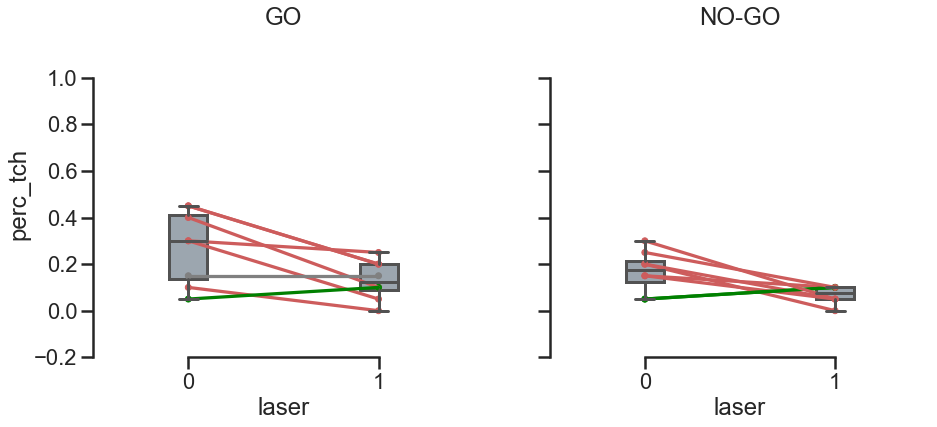

In [12]:
report_directory=r'U:\Data\snareddu\behavioral opto\Report/'
tmp1=perc_correct.groupby(['et','stim','laser']
                        ).apply(lambda x: x.loc[x['day'].idxmax()][['day','perc_tch']]).reset_index()


fig,ax=plt.subplots(1,2,sharey=True,figsize=(15,6))
pg.plot_paired(tmp1[(tmp1.stim==1)&(~tmp1.laser.isna())
                   ]
                  , dv='perc_tch', within='laser', subject='et',ax=ax[0])

pg.plot_paired(tmp1[(tmp1.stim==2)&(~tmp1.laser.isna())
                   ]
                  , dv='perc_tch', within='laser', subject='et',ax=ax[1])


ax[0].set_ylim(-0.2,1.2)
ax[1].set_yticks(np.arange(-0.2,1.2,0.2))
ax[1].set_ylim(-0.2,1.2)
ax[0].set_title('GO')
ax[1].set_title('NO-GO')


sns.despine(trim=True, ax=ax[0])
sns.despine(trim=True, ax=ax[1])


# plt.savefig(report_directory +'_opto_testday_paired_plot_together_within_laser_20tr.pdf',bbox_inches='tight')
# plt.savefig(report_directory +'_opto_testday_paired_plot_together_within_laser_20tr.png',bbox_inches='tight')

In [ ]:
### Wilcoxon signed rank test 

scipy.stats.wilcoxon(tmp1[(tmp1.stim==1)&(tmp1.laser==0)].perc_tch.values, 
                     tmp1[(tmp1.stim==1)&(tmp1.laser==1)].perc_tch.values, zero_method='wilcox', 
                     correction=False, alternative='two-sided', method='auto', axis=0, nan_policy='propagate',
                     keepdims=False)

scipy.stats.wilcoxon(tmp1[(tmp1.stim==2)&(tmp1.laser==0)].perc_tch.values, 
                     tmp1[(tmp1.stim==2)&(tmp1.laser==1)].perc_tch.values, zero_method='wilcox', 
                     correction=False, alternative='two-sided', method='auto', axis=0, nan_policy='propagate',
                     keepdims=False)